In [1]:
from gaussian_fermions import * #Can be installed with pip install gaussian_fermions
import time

tick = time.clock()
L = 20 #System length
N_shots = 1e4 #Whether to include Gaussian noise
N = 10 #Number of evolution times
T = 15 #Evolution time
beta = 3 #Inverse temperature

# (a) Create a thermal state
H_nnh = nearest_neighbor_hopping( L )
H_nnh.h = H_nnh.h + .3*np.diag( np.random.normal( 0, 10, L ) )
cov_thermal = H_nnh.cov_thermal( beta )

# (b) Choose initial state for reconstruction 
cov_ini =  cov_thermal

# (c) Quench to NN and evolve to equidistant times
H_quench = nearest_neighbor_hopping( L )
H_quench.h = H_quench.h +np.diag( range(cov_ini.shape[0]))
#H_quench = hopping_Hamiltonian( H_nnh.h + np.diag( range(cov_ini.shape[0])))
times = np.linspace( 0, T, N )

# (d) Sample number measurement statistics
data = [ H_quench.cov_evolve( cov_ini, t ).real.diagonal(0)  for t in times ]

N_sample_t = int(np.floor(N_shots / N))

data_resampled = []
for Ns in data:
    Ns_t = []
    for Nx in Ns:
        Ns_t.append(np.mean(np.random.binomial( size = N_sample_t, n=1, p = Nx )))

    data_resampled.append(Ns_t)

# (e) Run tomography
from hopping_tomography import * #Source: https://github.com/marekgluza/hopping_tomography

tomography = hopping_tomography( data_resampled, times, H_quench ) #Create an object using particle number data, times, and the model
tomography.recover_SDP( SDP_constraints = True, verbose = True)#, max_iters = 200 ) #, eps = 1e-5, max_iters = 2500 )
tock = time.clock()

print('Reconstruction finished in '+ str(tock-tick) + 'seconds')

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 291610
eps = 1.00e-05, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 1010, constraints m = 2450
Cones:	soc vars: 810, soc blks: 210
	sd vars: 1640, sd blks: 2
Setup time: 3.74e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.15e+20  2.83e+20  1.00e+00 -5.68e+21  3.63e+20  3.00e+21  1.77e-02 
   100| 1.27e-03  1.79e-03  1.50e-03  3.77e-01  3.80e-01  7.70e-16  9.80e-01 
   200| 2.13e-04  3.06e-04  8.70e-04  3.78e-01  3.79e-01  1.32e-16  1.79e+00 
   3

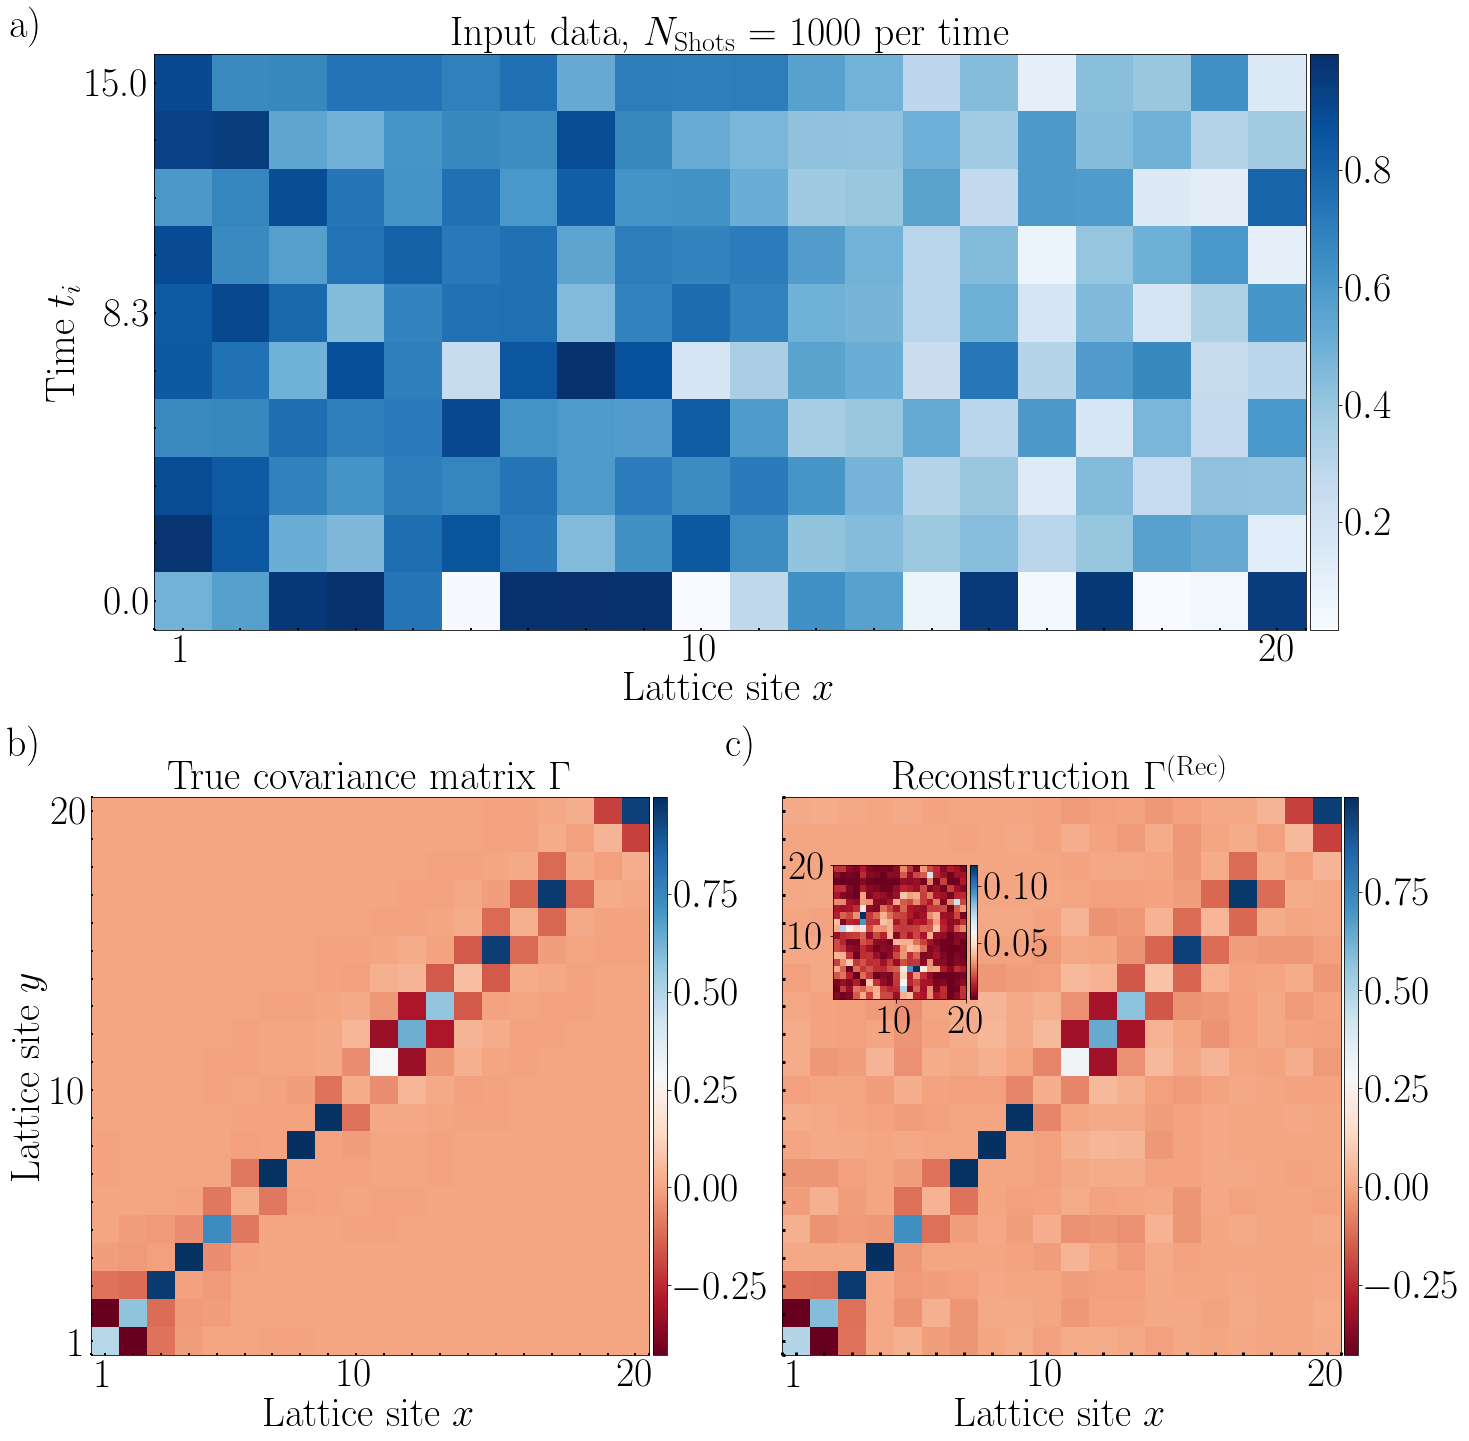

In [7]:
LL=tomography.LL
save_path = 'figs/app_Anderson_L_'+str(L)+'_T_'+str(T)+'_N_'+str(N)+'_N_shot_'+str(int(N_shots))+'.pdf'

fontsize = 40
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.size'] = fontsize
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.labelspacing'] = .3
plt.rcParams['legend.columnspacing']= .3
plt.rcParams['legend.handletextpad']= .1
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
#Main plot
fig = plt.figure( figsize = ( 20,20 ) )

data_pos_x  = 0.09
data_pos_y = .56
data_height = 0.4
data_width = 0.85

ini_pos_x  = 0.06
ini_pos_y = 0.05
ini_height = 0.4
ini_width = ini_height

rec_pos_x  = 0.54
rec_pos_y = .05
rec_height = 0.4
rec_width = rec_height

inset_pos_x = 0.575
inset_pos_y = 0.3   
inset_height = 0.1
inset_width = 0.1

label_a_x = -2.5
label_a_y = 1.03*N
label_b_x = -3
label_b_y = LL+1.5   
label_c_x = -2
label_c_y = label_b_y

## a)
#Input data
ax_input_data = fig.add_axes( [ data_pos_x, data_pos_y, data_width, data_height ] )   

im_input_data = ax_input_data.imshow( data, cmap='Blues', aspect = 'auto', interpolation = None, 
                                     extent= [0, LL, N, 0])
plt.text( label_a_x,label_a_y, 'a)')

N_per_time = (N_shots/ N)
title = r'Input data, $N_\mathrm{Shots}$ = %d per time' % N_per_time
plt.title( title )
plt.xlabel( 'Lattice site $x$' )
plt.ylabel( 'Time $t_i$' )
plt.clabel = r'$N_x(t)$'

#plt.grid() 

plt.xlim((0,LL))
N = len( times )        
plt.ylim((0,N))

ticks = np.append(0,np.linspace(0.5,LL-.5,LL))
ticks = np.append(ticks, LL)
tick_labels = ['']*(len(ticks))
tick_labels[1] = 1
tick_labels[int(LL/2)] = int(LL/2)
tick_labels[-2] = LL
plt.xticks(np.array(ticks),tick_labels)

ticks = np.append(0,np.linspace(.5,N-.5,N))
np.append(ticks,N)
tick_labels = ['']*(len(ticks))
tick_labels[1] = times[0]
tick_labels[int(N/2)+1] = round(times[int(N/2)],1)
tick_labels[-1] = times[-1]
plt.yticks(np.array(ticks),tick_labels)

ax_input_data.tick_params(direction='in', length=2, width=2, colors='k')#,    grid_color='k', grid_alpha=0.5)

divider = make_axes_locatable(ax_input_data)
cax = divider.append_axes("right", size="2.5%", pad=0.05)        
cbar = plt.colorbar(im_input_data, cax=cax)
#cbar.set_clim( 0, 1 )
ax_input_data.set_aspect(1)

## b)
#Plot cov_ini
ax_cov_ini = fig.add_axes( [ ini_pos_x, ini_pos_y, ini_width, ini_height ] )

im_cov_ini = ax_cov_ini.imshow( (cov_ini), cmap='RdBu', aspect='equal', interpolation = None, 
                               extent = [ 0, LL, LL, 0])
plt.text( label_b_x,label_b_y, 'b)')

title = r'True covariance matrix $\Gamma$'
plt.title( title )
plt.xlim((1,LL))
plt.ylim((1,LL))
plt.xlabel( 'Lattice site $x$' )
plt.ylabel( 'Lattice site $y$' )
#plt.grid()
ticks = np.append(0,np.linspace(0.5,LL-.5,LL))
ticks = np.append(ticks,LL)
tick_labels = ['']*(len(ticks))
tick_labels[1] = 1
tick_labels[int(LL/2)] = int(LL/2)
tick_labels[-2] = LL

plt.xticks(np.array(ticks),tick_labels)
plt.yticks(np.array(ticks),tick_labels)
ax_cov_ini.tick_params(direction='in', length=2, width=2, colors='k')
divider = make_axes_locatable(ax_cov_ini)
cax = divider.append_axes("right", size="2.5%", pad=0.05)

cbar = plt.colorbar(im_cov_ini, cax=cax)
range_plot = np.max( np.abs( cov_ini ) )
#cbar.set_clim( -range_plot, range_plot )

## c)
#Plot cov reconstructed + inset deviation

ax_cov_rec = fig.add_axes( [ rec_pos_x, rec_pos_y, rec_width, rec_height ] )
cov_rec = (tomography.Gamma)
inset_cov = abs( cov_ini - tomography.Gamma )
im_cov_rec = ax_cov_rec.imshow( cov_rec.real, cmap='RdBu', aspect='equal', interpolation = None, 
                               extent = [ 0, LL, LL, 0])
plt.text( label_c_x,label_c_y, 'c)')

title = r'Reconstruction $\Gamma^{\rm(Rec)}$'
plt.title( title )
#plt.grid()
plt.xlim((1,LL))
plt.ylim((1,LL))
plt.xlabel( 'Lattice site $x$' )
plt.xticks(np.array(ticks),tick_labels)
plt.yticks(ticks,[])
ax_cov_rec.tick_params(direction='in', length=3, width=3, colors='k')

divider = make_axes_locatable( ax_cov_rec )
cax_cov_rec = divider.append_axes("right", size="2.5%", pad=0.05)

cbar = plt.colorbar( im_cov_rec, cax = cax_cov_rec )
range_plot = np.max( np.abs( cov_rec ) )
#cbar.set_clim( -range_plot, range_plot )

#inset 
inset = fig.add_axes( [ inset_pos_x, inset_pos_y, inset_width, inset_height ] )
im2 = inset.imshow( inset_cov, extent = [ 1, LL, LL, 1], cmap='RdBu', aspect='equal', interpolation = None)
plt.xlim((1,LL))
plt.ylim((1,LL))
divider2 = make_axes_locatable(inset)
cax_cov_rec2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax = cax_cov_rec2 )
range_plot = np.max( np.abs( inset_cov ) )
#cbar2.set_clim( -range_plot, range_plot )
cbar2.set_ticks( [ round(range_plot,1)/2,round(range_plot,1)])

plt.savefig( save_path, format='pdf')
plt.show()
